# Initial Exploration

## Problem description

Let f(x, P) be a neural network with fixed structure that takes as input a feature vector x and computes a real-valued output based on learnable parameters P.  Suppose that in response to a training example, the parameters are updated to P'.  The difference between the value of the function before and after the update is:

f(x, P) - f(x, P')

We would like a network that generalizes in the neighborhood of x.  That is, if x' is an input vector “close” to x, we would like the change in f due to the change in P at x to be similar in sign and magnitude to the change in f at x' due to the change in P.  The latter quantity can be written:

f(x', P) - f(x', P')

They are similar if the following loss is _all:

L\_gen = ((f(x, P) - f(x, P')) - (f(x', P) - f(x', P'))^2

If I update the parameters from P to P', the change in f should be similar in the neighborhood of x.  As |x - x'| gets larger, the neighborhood of the generalization increases.

Our goal is to pre-train a network using unlabeled data to get into a part of the parameter space such that generalization during pre-training is broad, thereby leading to faster convergence.  Consider the following algorithmic approach to this idea.


```
Input: X = {x1, x2, , xn}, neural network f, x, P
x is the standard deviation of the noise applied to x
p is the standard deviation of the noise applied to P

While not converged
  Choose x from X at random
  x’ = x + N(0, x)
  P’ = P + N(0, P)
  Compute derivative of  Lgen wrt P
  Update P using gradient descent

Return P
```gradient descent

Return P


In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [2]:
class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ELU(),
            nn.Linear(10, 30),
            nn.ELU(),
            nn.Linear(30, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class FunctionDataset(Dataset):
    
    def __init__(self, function, num_samples, start=0, stop=2*math.pi, rand_pts=False, noise=0):
        self.num_samples = num_samples
        self.start = start
        self.stop = start
        self.noise = noise

        if not rand_pts:
            pts = np.linspace(start, stop, num_samples)
            self.data = torch.from_numpy(pts).to(torch.float32)
        else:
            self.data = torch.sort(torch.zeros((num_samples,), dtype=torch.float32).uniform_(start, stop))
        
        self.labels = function(self.data).to(torch.float32)
        self.labels = self.labels + torch.normal(0, noise,  self.labels.shape)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label = self.labels[idx]
        return self.data[idx], label

    def get_data(self):
        return self.data

    def get_labels(self):
        return self.labels
        

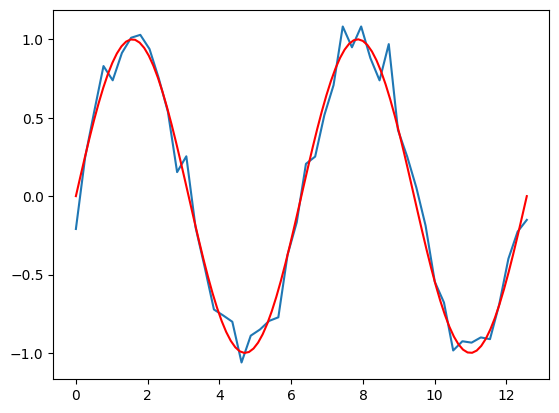

In [4]:
train_noise = 0.1

train_data = FunctionDataset(torch.sin, 50, stop=4*math.pi, noise=train_noise)
test_data = FunctionDataset(torch.sin, 100, stop=4*math.pi, rand_pts=False)
plt.plot(train_data.get_data().numpy(), train_data.get_labels().numpy())
plt.plot(test_data.get_data().numpy(), test_data.get_labels().numpy(), color='red')

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [5]:
learning_rate = 1e-2
epochs = 200

# all models should have the same initial weights
sin_model = TinyModel()
precond_model = copy.deepcopy(sin_model)
jittered_model = copy.deepcopy(sin_model)
# would fixing torch.random_seed() here allow 
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(sin_model.parameters(), lr=learning_rate)

In [6]:
# Taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html and somewhat altered
def train_loop(dataloader, model, loss_fn, optimizer, jitter=0):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X + torch.normal(0, jitter, X.shape))
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        
    return total_loss / batches

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    xs = []
    ys = []
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            xs.append(X.item())
            preds.append(pred.item())
            ys.append(y.item())
            test_loss += loss_fn(pred, y).item()

    plt.scatter(xs, ys, label="True points")
    plt.scatter(xs, preds, label="Predictions")
    plt.legend()

    plt.show()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [7]:
# Based off Mohammad M's initial code sample
def nbd_loss(a, b, c, d):
    return torch.sum(((a-b) - (c-d))**2)

def precond_loop(network, network_prime, dataloader, four_loss, optimizer, std=.05):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):

        optimizer.zero_grad()
        x_prime = X + torch.normal(0, std, X.shape)
        
        param_prime = {}
        for name, p in network.state_dict().items():
            param_prime[name] = p.clone() + torch.normal(0, std, p.shape)
            param_prime[name].requires_grad = False
        network_prime.load_state_dict(param_prime)

        # forward 1: f(x, p)
        y_x_p = network(X)
        # forward 2: f(x', p)
        y_xp_p = network(x_prime)
        # forward 3: f(x, p')
        y_x_pp = network_prime(X)
        # forward 4: f(x', p')
        y_xp_pp = network_prime(x_prime)
        
        loss = four_loss(y_x_p, y_x_pp, y_xp_p, y_xp_pp)
        
        # backward: calculating the gradients w.r.t. p. Gradients of p' is turned off in line 44
        loss.backward()
        # update weights
        optimizer.step()
        total_loss += loss.item()
    return total_loss / batch

def model_residual_F(model_a: torch.nn.Module, model_b: torch.nn.Module):
    # assumes model_a and model_b have the same shape & weights
    with torch.no_grad():
        a_dict = model_a.state_dict()
        
        b_dict = model_b.state_dict() if model_b is not None else None
        total = 0
        for param_name in a_dict.keys():
            if b_dict is not None:
                partial_resid = a_dict[param_name] - b_dict[param_name]
                partial_resid = partial_resid ** 2
            else:
                partial_resid = a_dict[param_name] ** 2
            total += torch.sum(partial_resid).item()
    
        return total ** 0.5

Epoch: 1


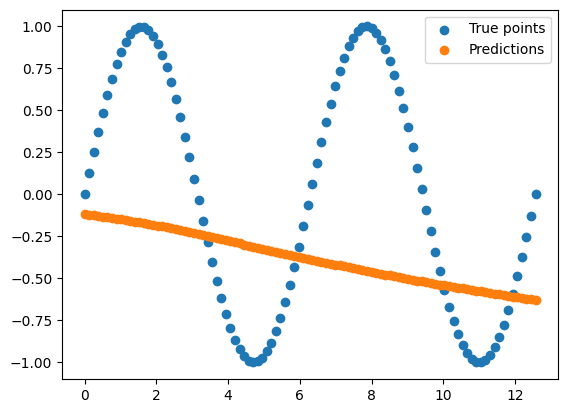

Avg loss: 0.579464 

Epoch: 2


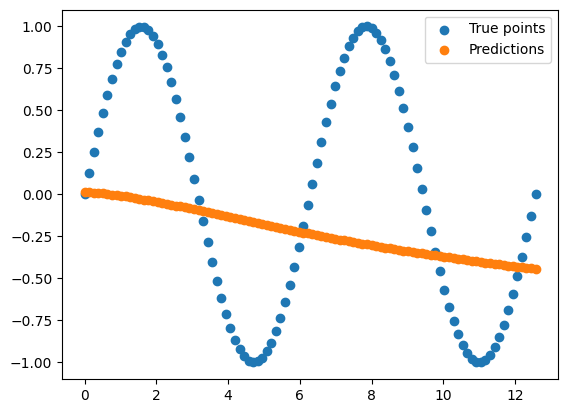

Avg loss: 0.489848 

Epoch: 3


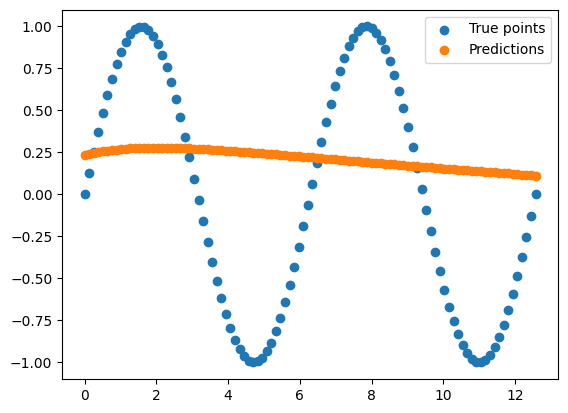

Avg loss: 0.517940 

Epoch: 4


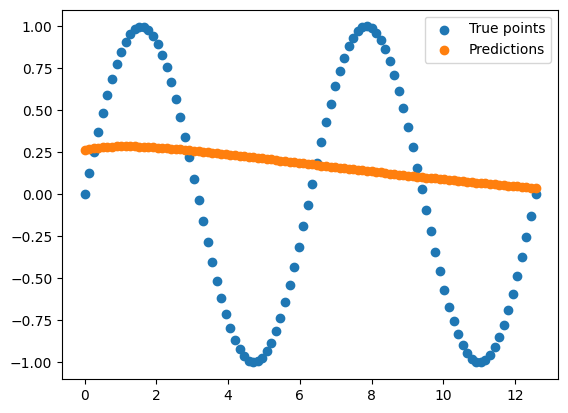

Avg loss: 0.491518 

Epoch: 5


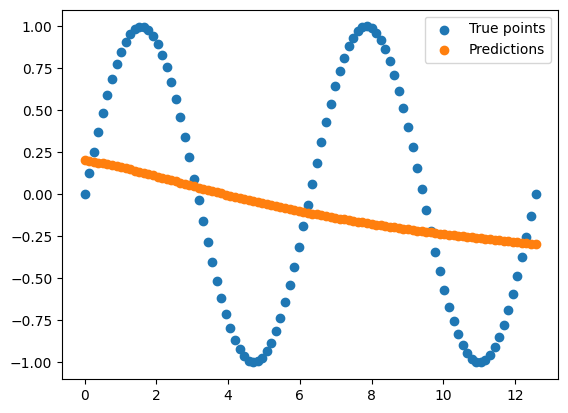

Avg loss: 0.443060 

Epoch: 6


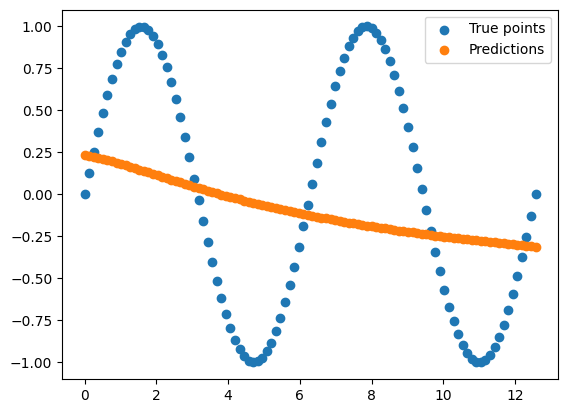

Avg loss: 0.440695 

Epoch: 7


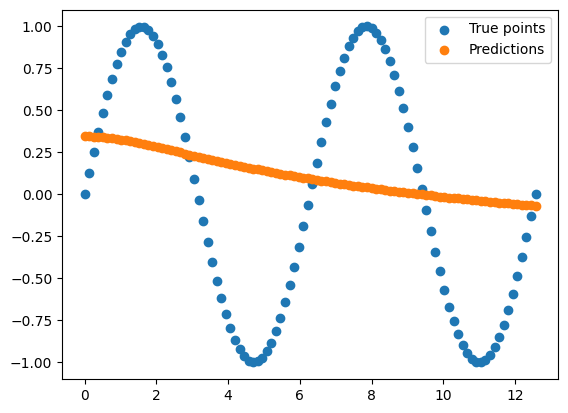

Avg loss: 0.454887 

Epoch: 8


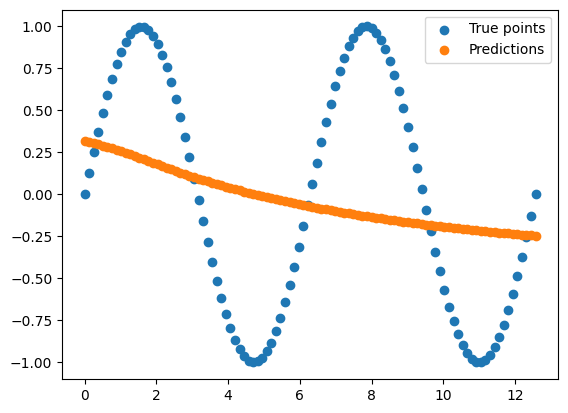

Avg loss: 0.431534 

Epoch: 9


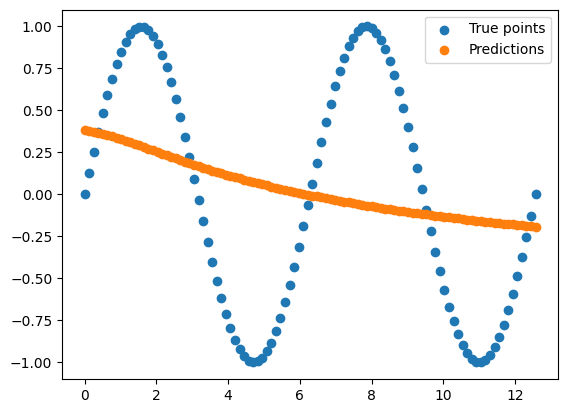

Avg loss: 0.430939 

Epoch: 10


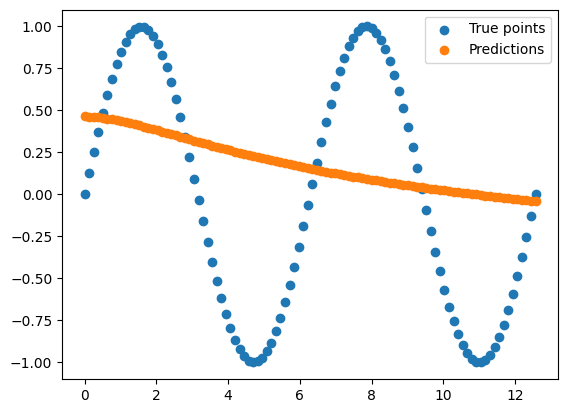

Avg loss: 0.467444 

Epoch: 11


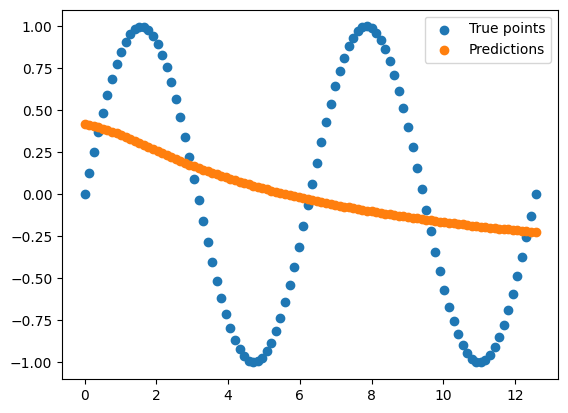

Avg loss: 0.425551 

Epoch: 12


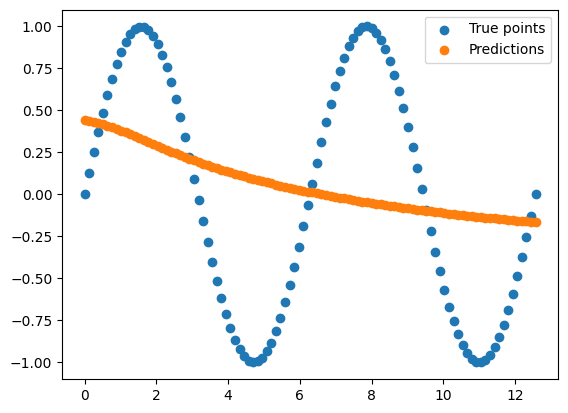

Avg loss: 0.430711 

Epoch: 13


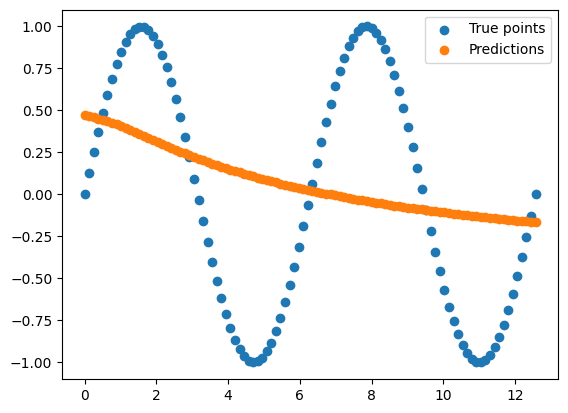

Avg loss: 0.430730 

Epoch: 14


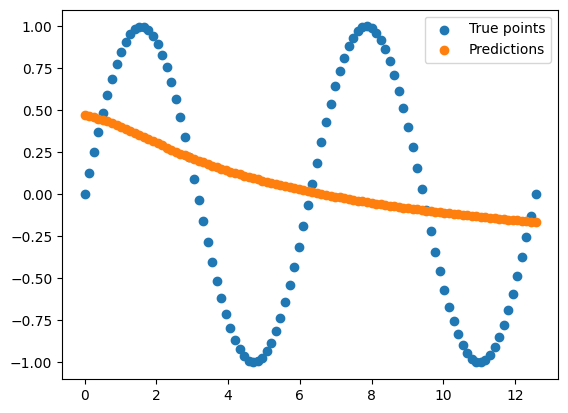

Avg loss: 0.429665 

Epoch: 15


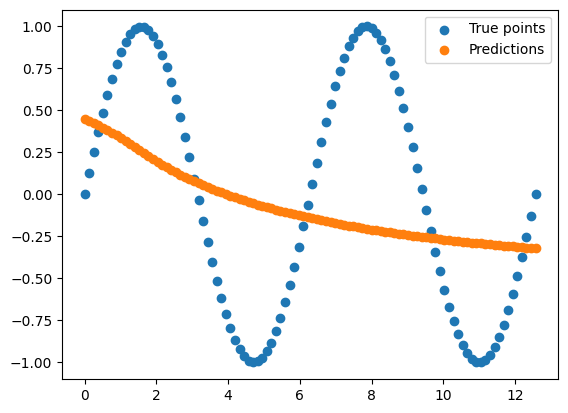

Avg loss: 0.424317 

Epoch: 40


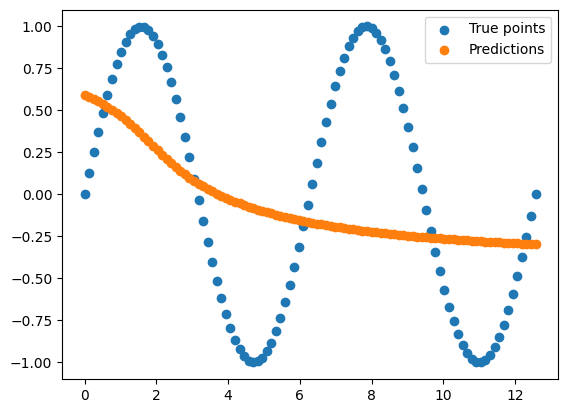

Avg loss: 0.412967 

Epoch: 80


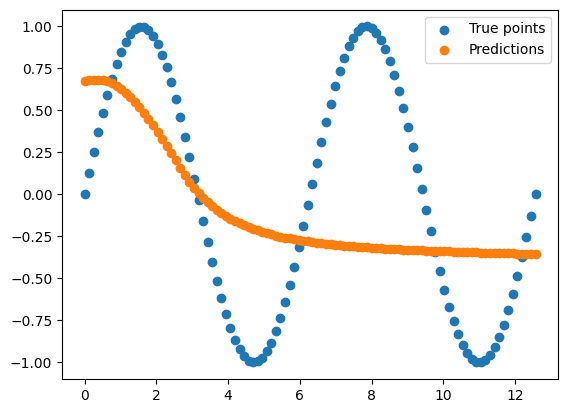

Avg loss: 0.402927 

Epoch: 120


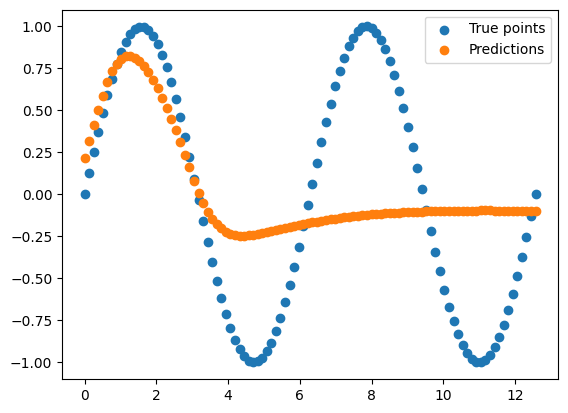

Avg loss: 0.335816 

Epoch: 160


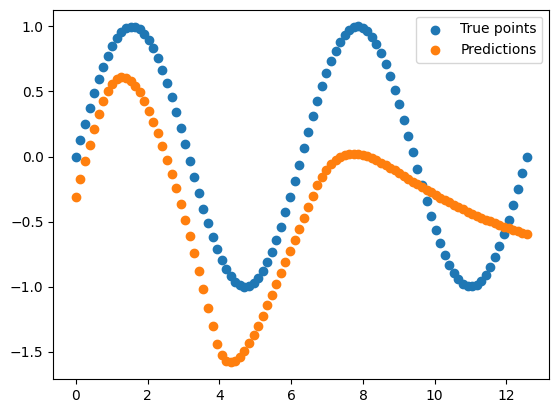

Avg loss: 0.305201 

Epoch: 200


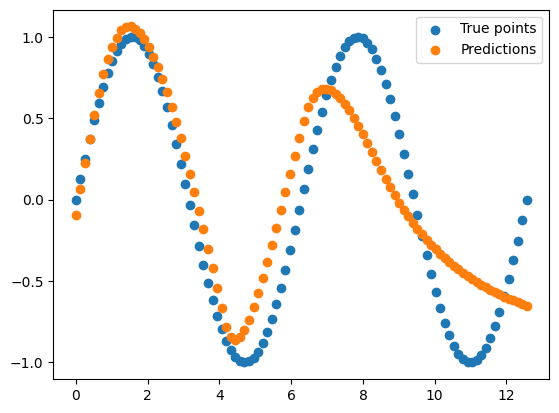

Avg loss: 0.108036 

Done!


In [8]:
standard_train_losses = []

for t in range(epochs):
    
    standard_train_losses.append(train_loop(train_dataloader, sin_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, sin_model, loss_function)
print("Done!")

In [9]:
# Pretraining:
precond_epochs = 50
precond_prime = TinyModel()

precond_lr = 1e-2
precond_optimizer = torch.optim.SGD(precond_model.parameters(), lr=precond_lr)


precond_losses = []
precond_training_losses = []

Epoch: 1


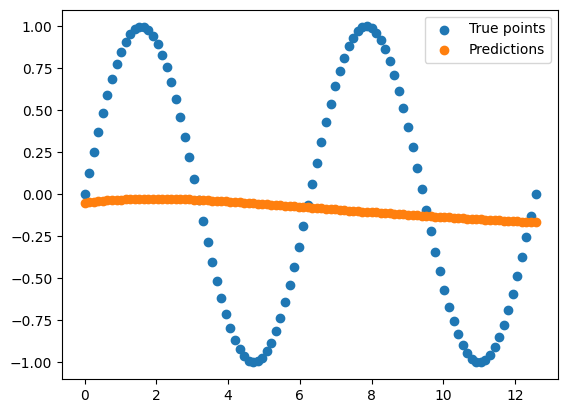

Avg loss: 0.482486 

Epoch: 2


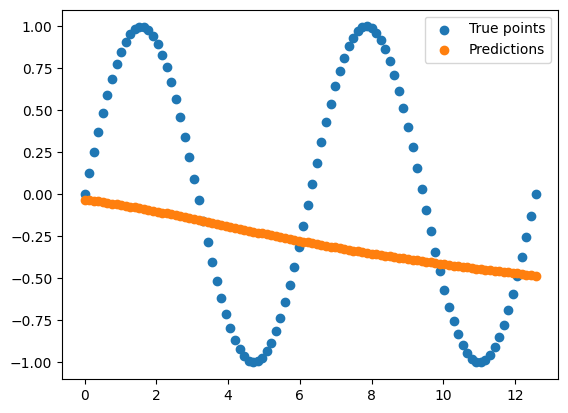

Avg loss: 0.515786 

Epoch: 3


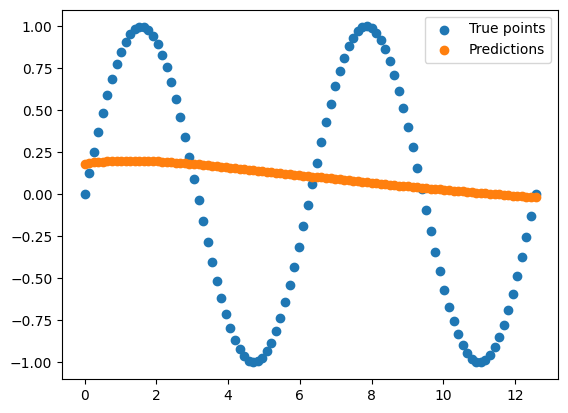

Avg loss: 0.475050 

Epoch: 4


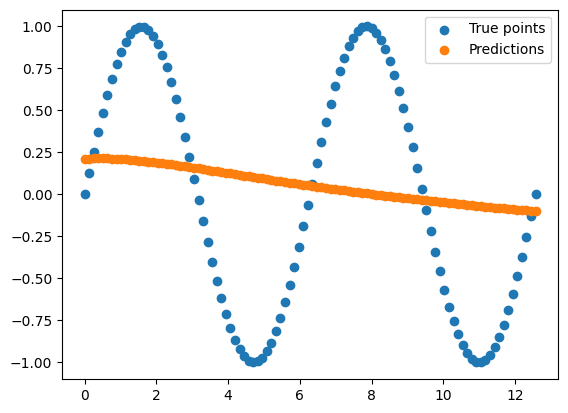

Avg loss: 0.455714 

Epoch: 5


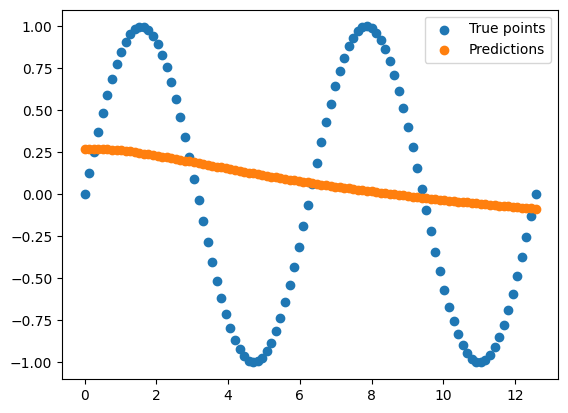

Avg loss: 0.454187 

Epoch: 6


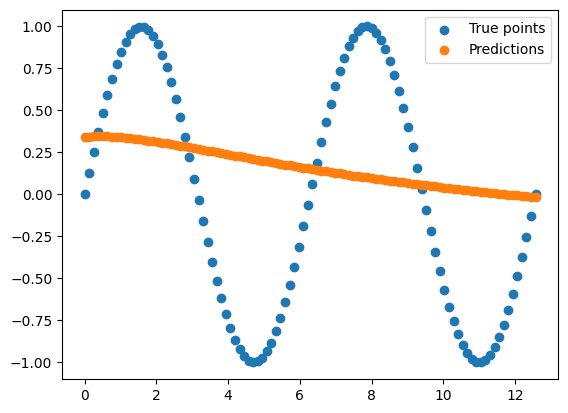

Avg loss: 0.473728 

Epoch: 7


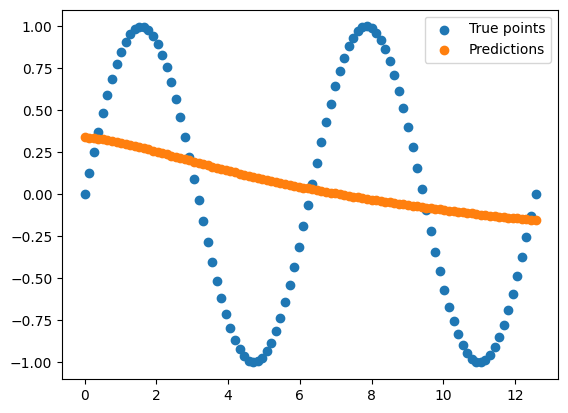

Avg loss: 0.439124 

Epoch: 8


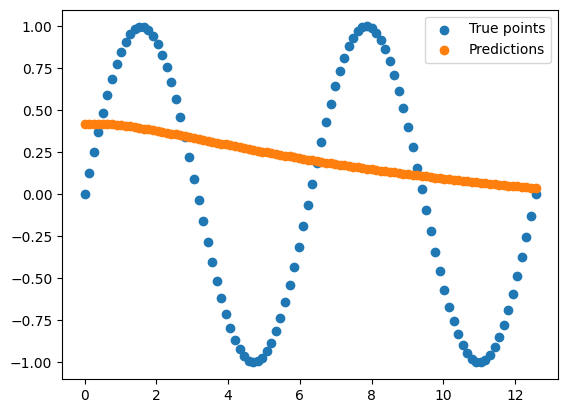

Avg loss: 0.493179 

Epoch: 9


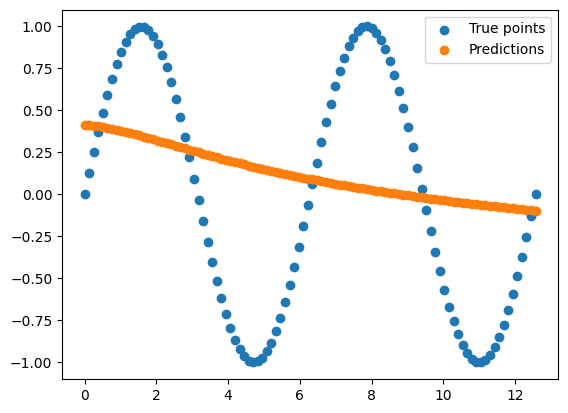

Avg loss: 0.448656 

Epoch: 10


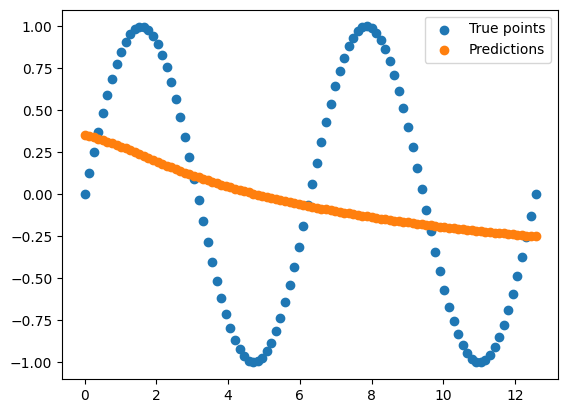

Avg loss: 0.428357 

Epoch: 11


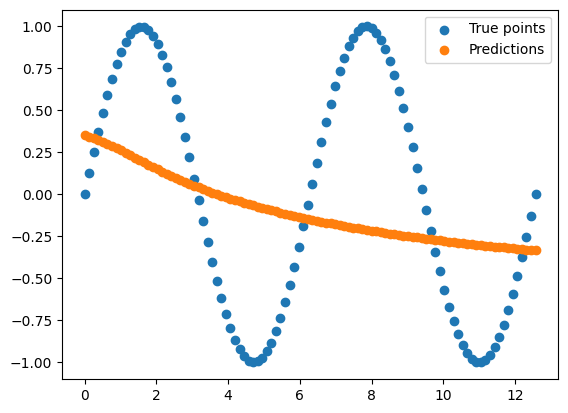

Avg loss: 0.431846 

Epoch: 12


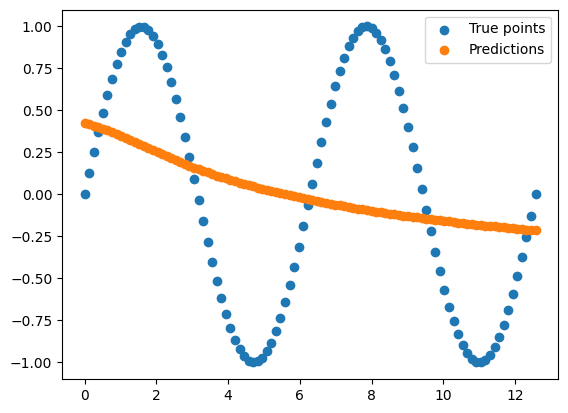

Avg loss: 0.425742 

Epoch: 13


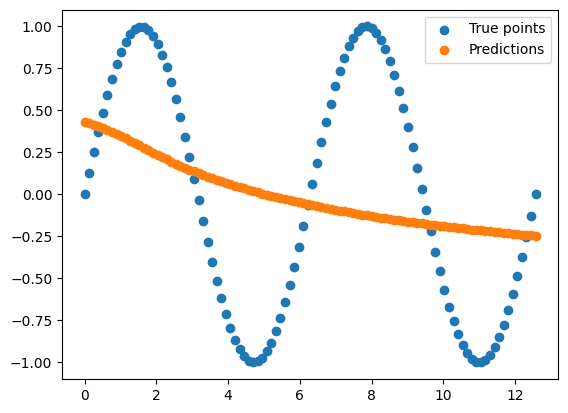

Avg loss: 0.423206 

Epoch: 14


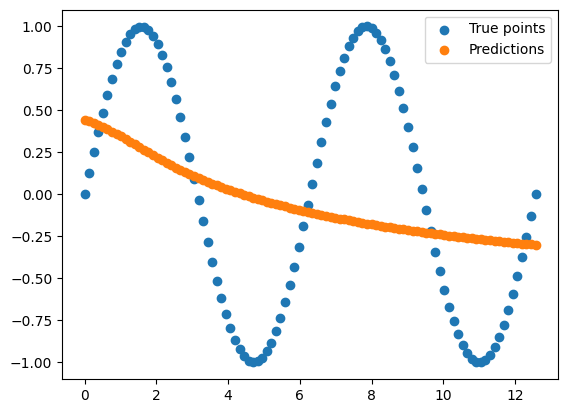

Avg loss: 0.422090 

Epoch: 15


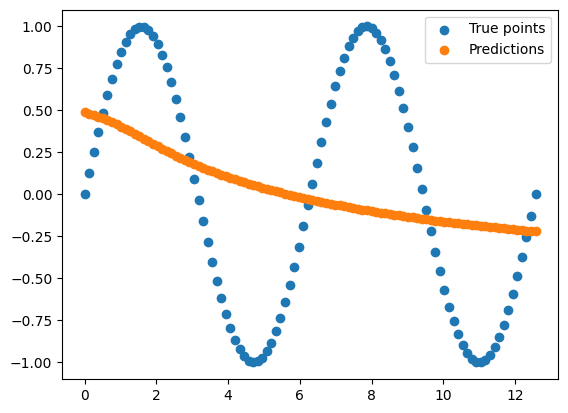

Avg loss: 0.422121 

Epoch: 40


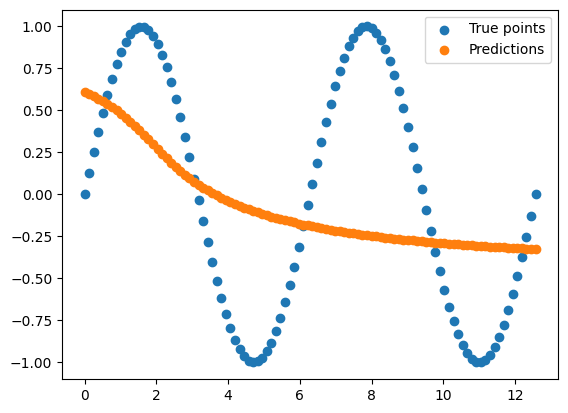

Avg loss: 0.413319 

Epoch: 80


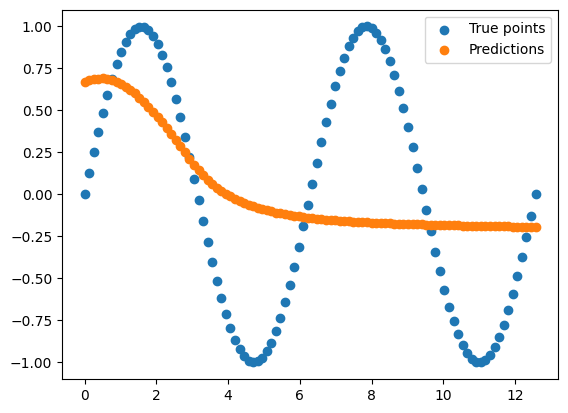

Avg loss: 0.393033 

Epoch: 120


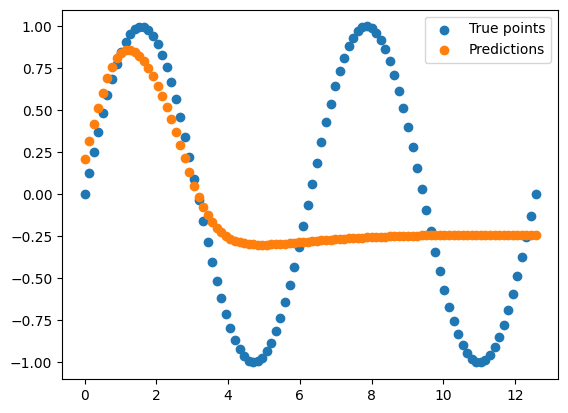

Avg loss: 0.344898 

Epoch: 160


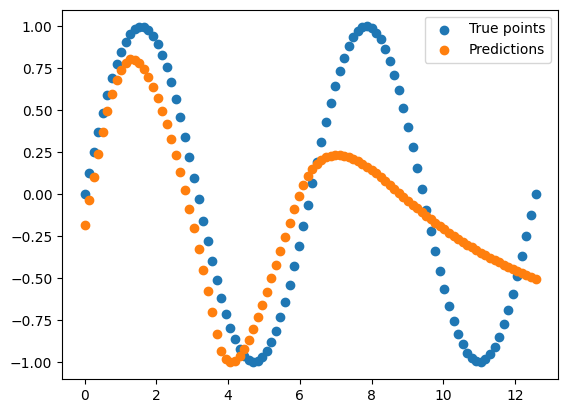

Avg loss: 0.170635 

Epoch: 200


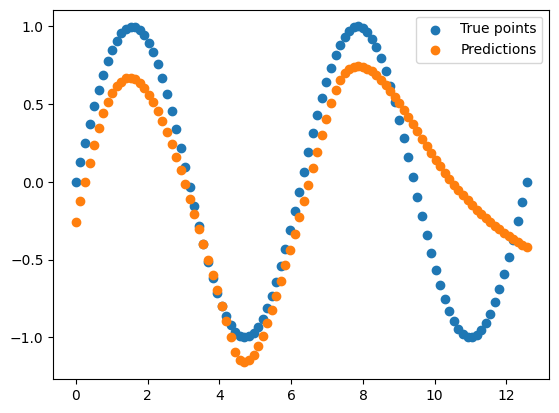

Avg loss: 0.135662 

Done!


In [10]:
original_model = copy.deepcopy(precond_model)

for t in range(precond_epochs):
    precond_losses.append(precond_loop(precond_model, precond_prime, train_dataloader, nbd_loss, precond_optimizer))
    
residual = model_residual_F(precond_model, original_model)

# we will use the same preconditioning to train a model for cosine
cos_precond_model = copy.deepcopy(precond_model)

training_optimizer = torch.optim.SGD(precond_model.parameters(), lr=learning_rate)
for t in range(epochs):
    
    precond_training_losses.append(train_loop(train_dataloader, precond_model, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, precond_model, loss_function)
print("Done!")

In [11]:
print(f"Norm of untrained model:", model_residual_F(original_model, None))
print(f"Norm of trained standard model:", model_residual_F(sin_model, None))
print(f"Norm of trained preconditioned model:", model_residual_F(precond_model, None))
print(f"Residual from preconditioning:", residual)
print(f"Residual between trained models:", model_residual_F(precond_model, sin_model))

Norm of untrained model: 4.551110664404937
Norm of trained standard model: 6.430781252871427
Norm of trained preconditioned model: 6.394307295152135
Residual from preconditioning: 0.0007086769946157381
Residual between trained models: 0.2197606160428751


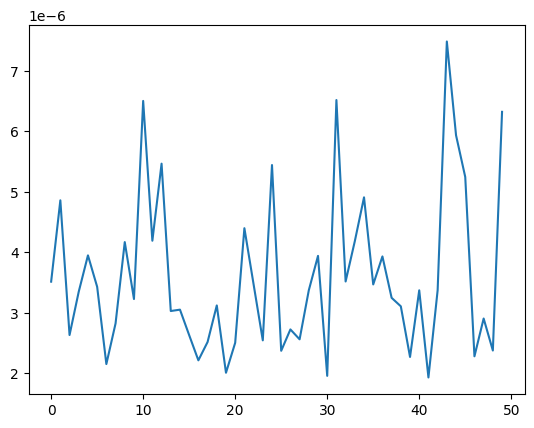

In [12]:
plt.plot(list(range(precond_epochs)), precond_losses)

Epoch: 1


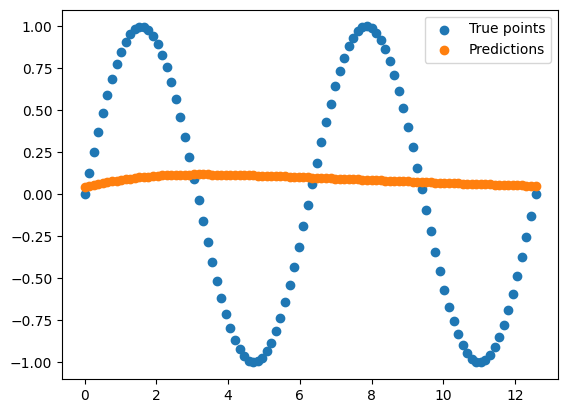

Avg loss: 0.499956 

Epoch: 2


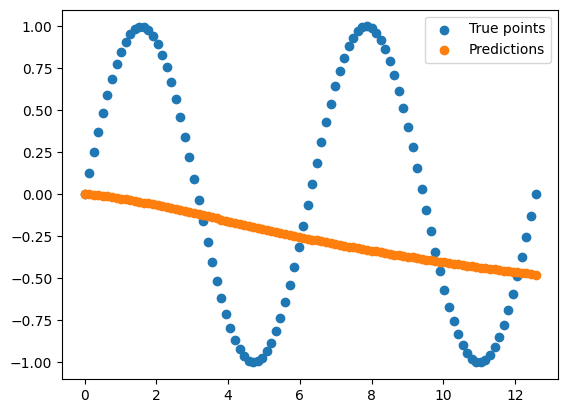

Avg loss: 0.501158 

Epoch: 3


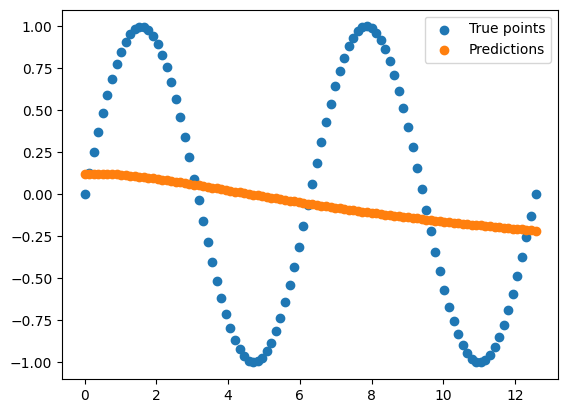

Avg loss: 0.451962 

Epoch: 4


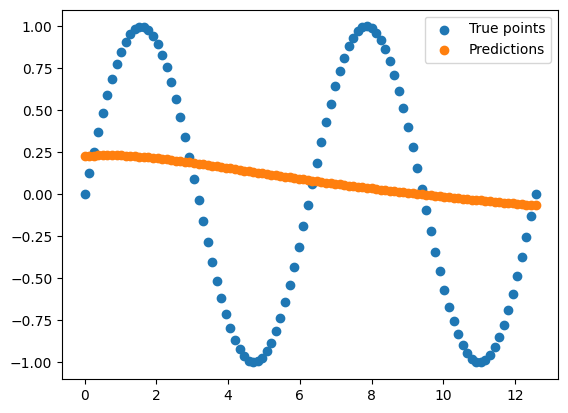

Avg loss: 0.461985 

Epoch: 5


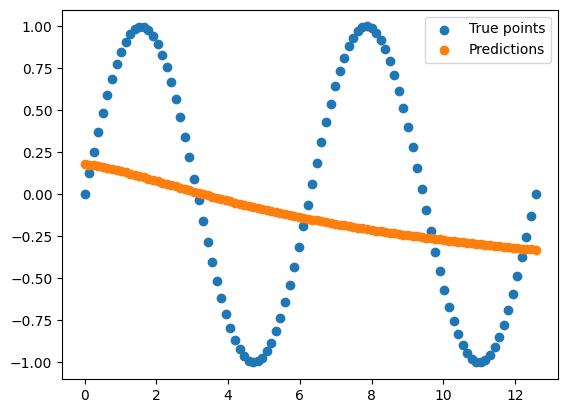

Avg loss: 0.448292 

Epoch: 6


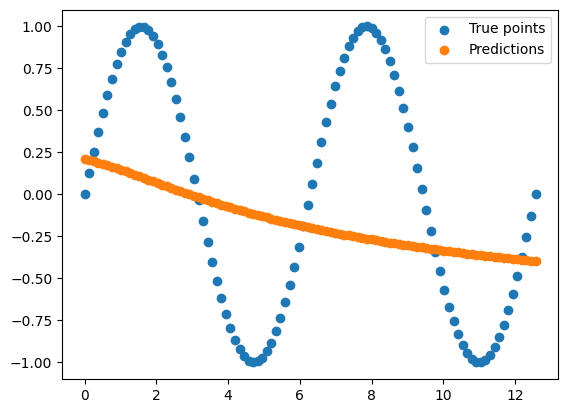

Avg loss: 0.453271 

Epoch: 7


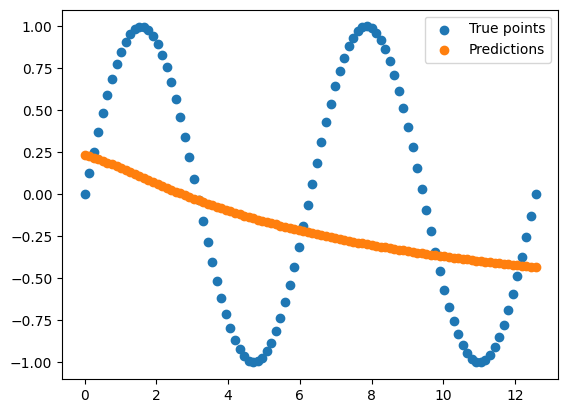

Avg loss: 0.457737 

Epoch: 8


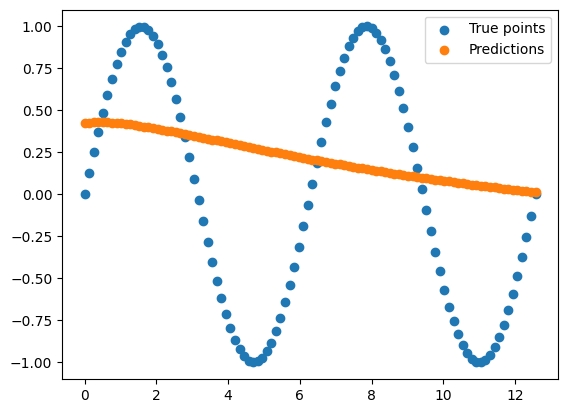

Avg loss: 0.491411 

Epoch: 9


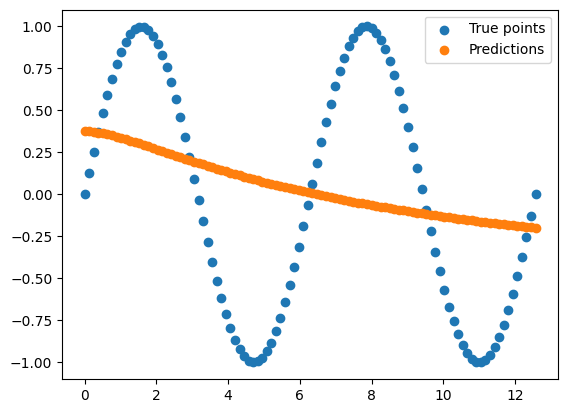

Avg loss: 0.431663 

Epoch: 10


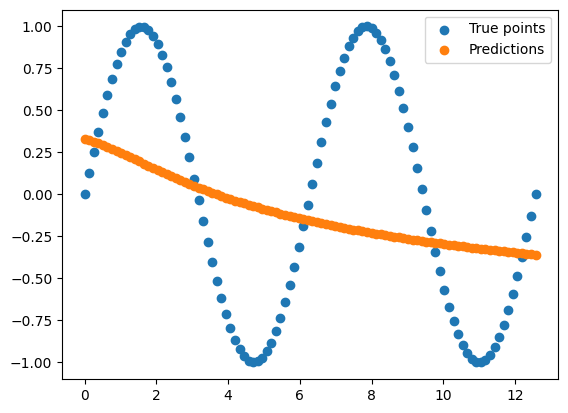

Avg loss: 0.434335 

Epoch: 11


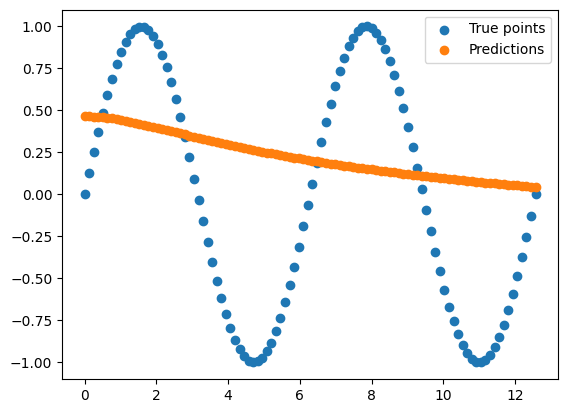

Avg loss: 0.492543 

Epoch: 12


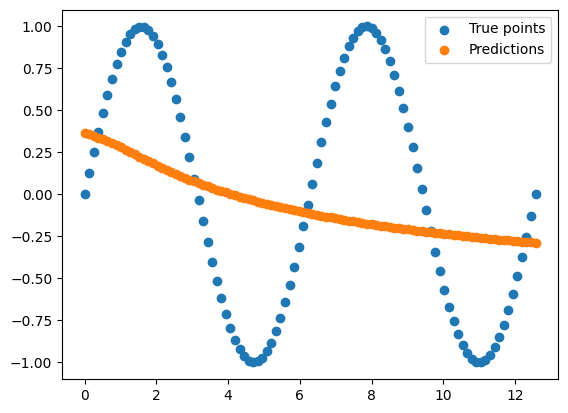

Avg loss: 0.428365 

Epoch: 13


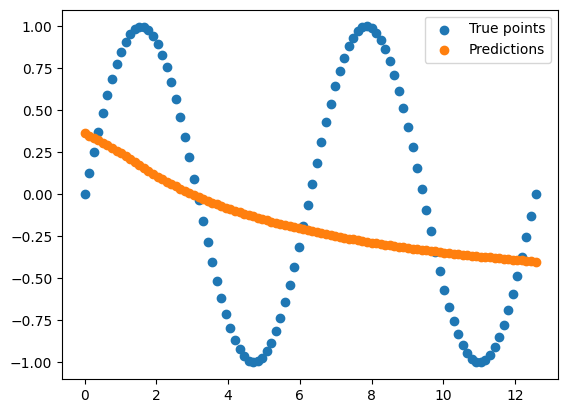

Avg loss: 0.442841 

Epoch: 14


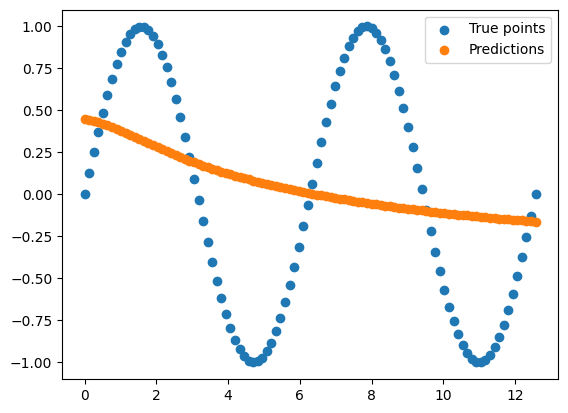

Avg loss: 0.429758 

Epoch: 15


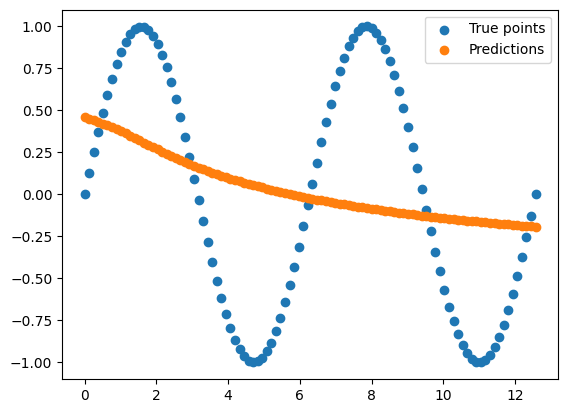

Avg loss: 0.425435 

Epoch: 40


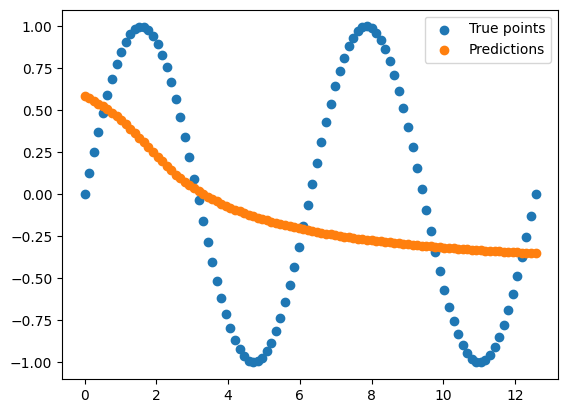

Avg loss: 0.419241 

Epoch: 80


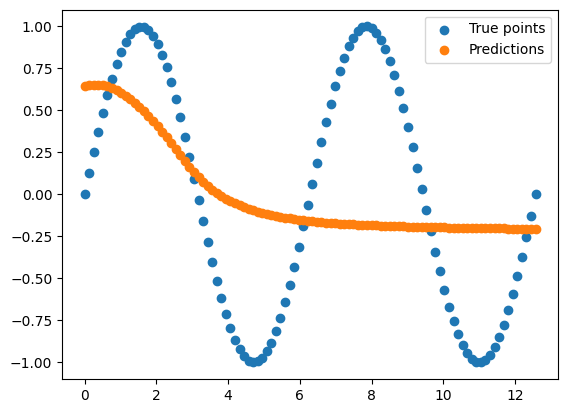

Avg loss: 0.394066 

Epoch: 120


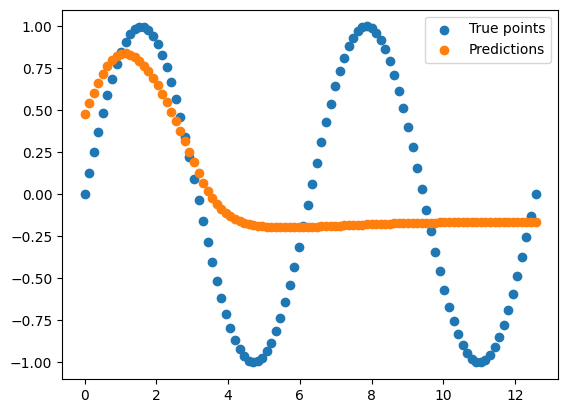

Avg loss: 0.359235 

Epoch: 160


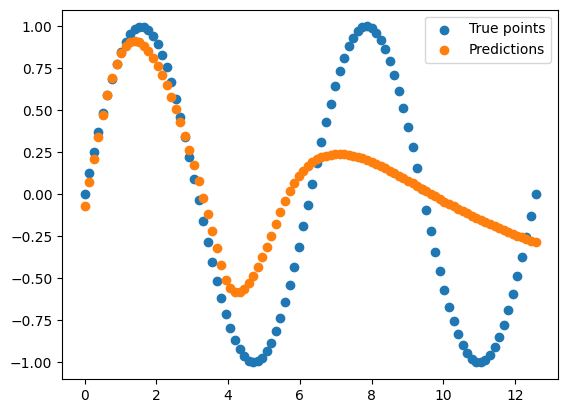

Avg loss: 0.206476 

Epoch: 200


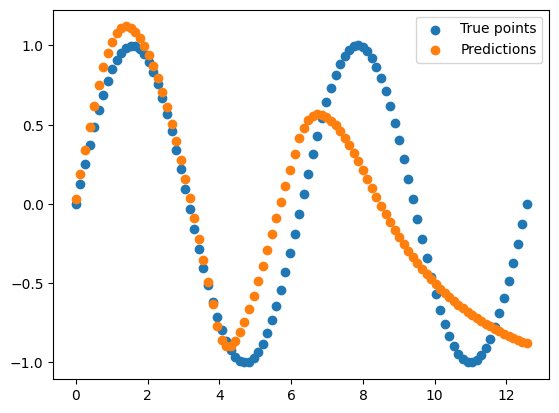

Avg loss: 0.144576 

Done!


In [13]:
jitter_std = 0.05

jitter_train_data = FunctionDataset(torch.sin, 50, stop=4*math.pi, noise=train_noise)
jitter_train_loader = DataLoader(jitter_train_data, shuffle=True)

loss_function = nn.MSELoss()
jitter_optimizer = torch.optim.SGD(jittered_model.parameters(), lr=learning_rate)

jitter_train_losses = []

for t in range(epochs):
    jitter_train_losses.append(train_loop(jitter_train_loader, jittered_model, loss_function, jitter_optimizer, jitter=jitter_std))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, jittered_model, loss_function)
print("Done!")

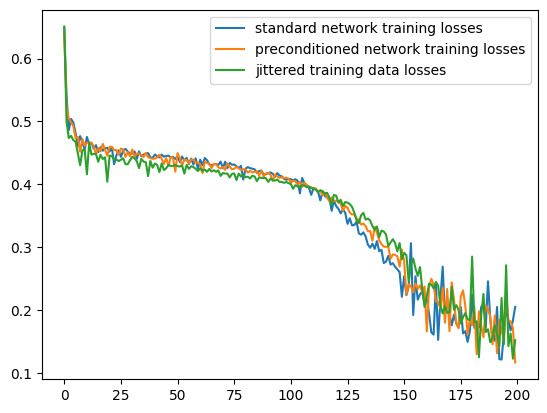

In [14]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
plt.plot(list(range(epochs)), jitter_train_losses, label="jittered training data losses")
plt.legend()

## Using a copy of the same preconditioned network to learn a different function

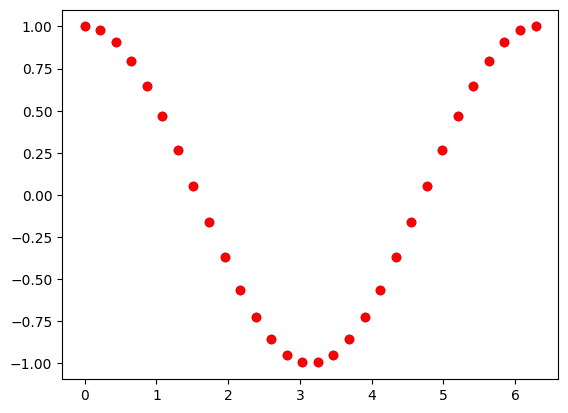

In [15]:
cos_train_data = FunctionDataset(torch.cos, 30)
cos_test_data = FunctionDataset(torch.cos, 30, rand_pts=False)
plt.scatter(cos_train_data.get_data().numpy(), cos_train_data.get_labels().numpy())
plt.scatter(cos_test_data.get_data().numpy(), cos_test_data.get_labels().numpy(), color='red')

cos_train_dataloader = DataLoader(cos_train_data, batch_size=1, shuffle=True)
cos_test_dataloader = DataLoader(cos_test_data, batch_size=1, shuffle=True)


In [16]:
learning_rate = 1e-2
epochs = 200

cos_model = copy.deepcopy(original_model)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(cos_model.parameters(), lr=learning_rate)

Epoch: 1


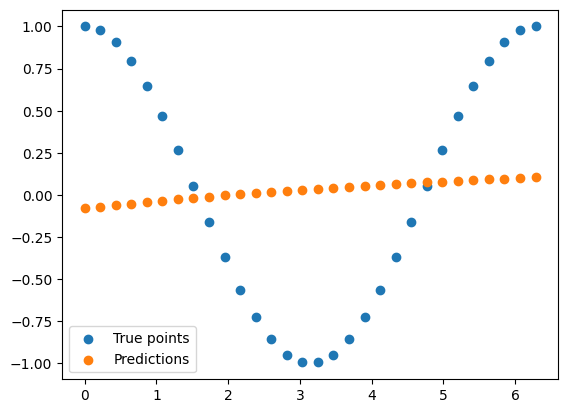

Avg loss: 0.528364 

Epoch: 2


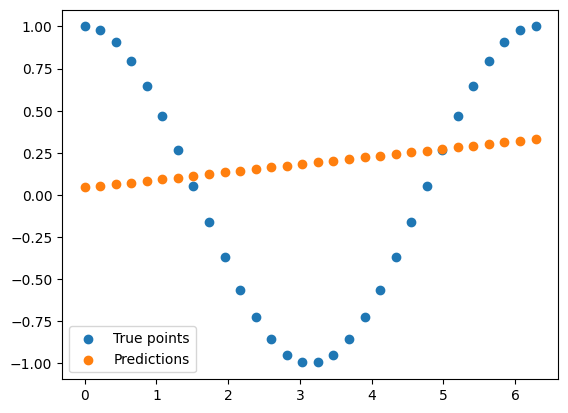

Avg loss: 0.547762 

Epoch: 3


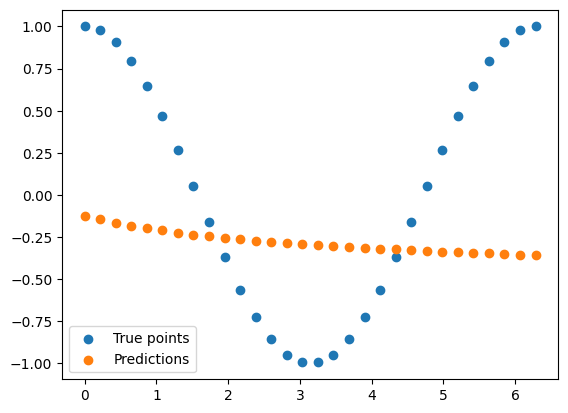

Avg loss: 0.593833 

Epoch: 4


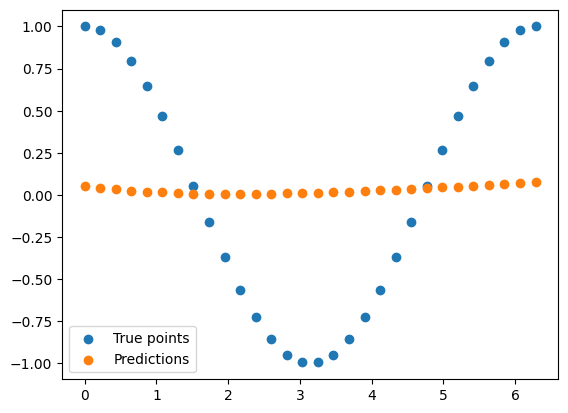

Avg loss: 0.494484 

Epoch: 5


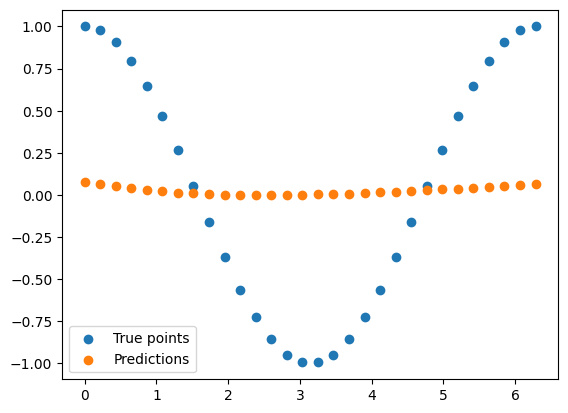

Avg loss: 0.486539 

Epoch: 6


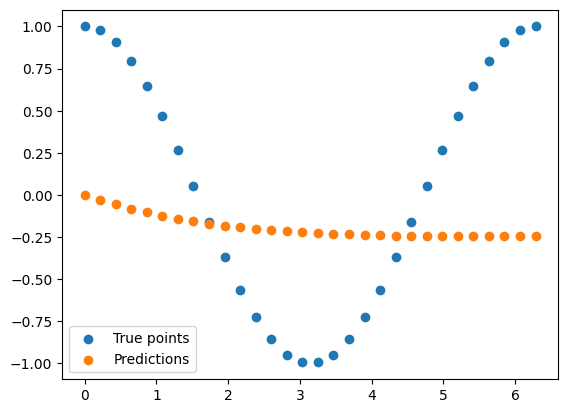

Avg loss: 0.526183 

Epoch: 7


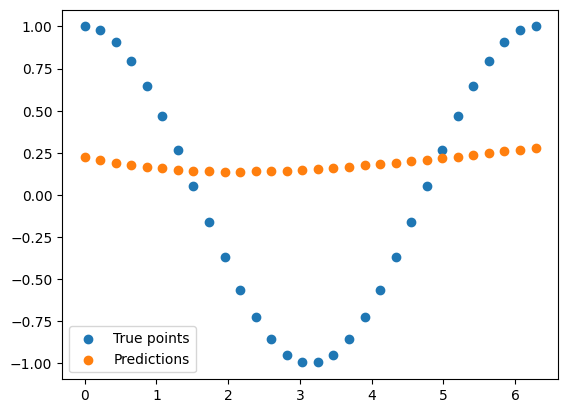

Avg loss: 0.497874 

Epoch: 8


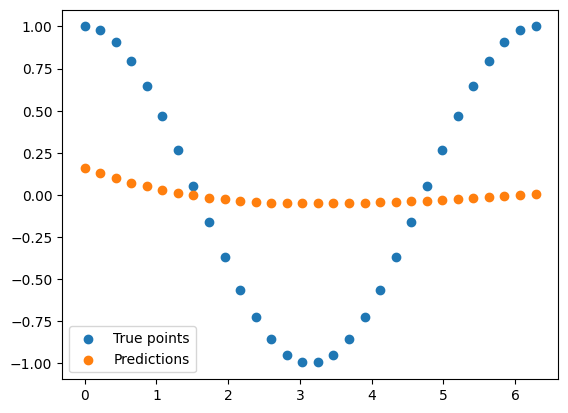

Avg loss: 0.463089 

Epoch: 9


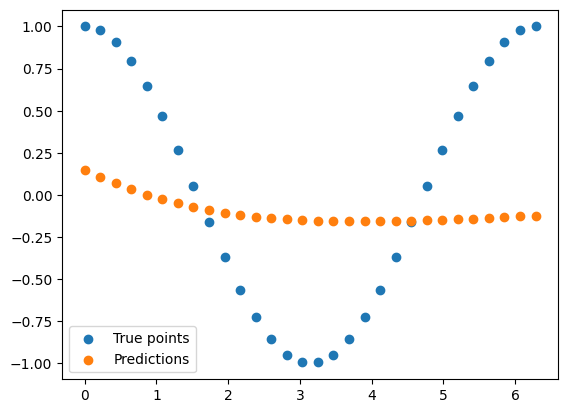

Avg loss: 0.468116 

Epoch: 10


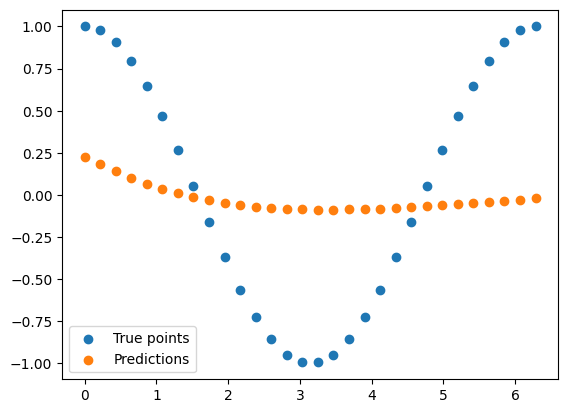

Avg loss: 0.443635 

Epoch: 11


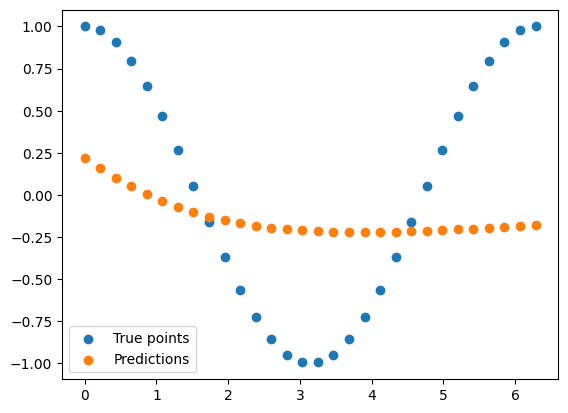

Avg loss: 0.457447 

Epoch: 12


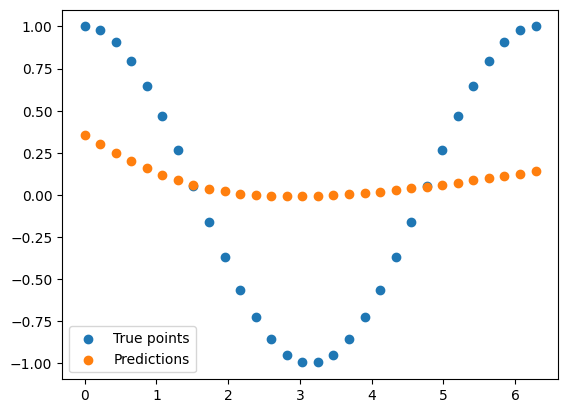

Avg loss: 0.415337 

Epoch: 13


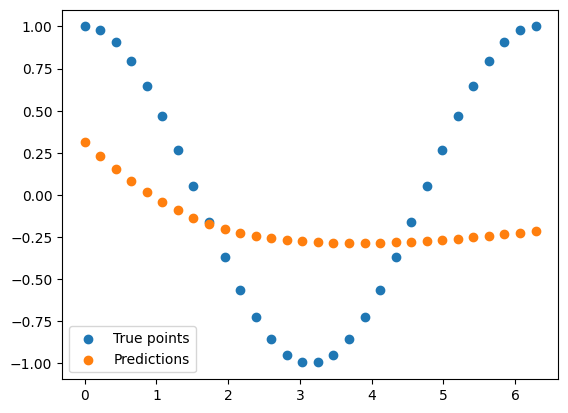

Avg loss: 0.441922 

Epoch: 14


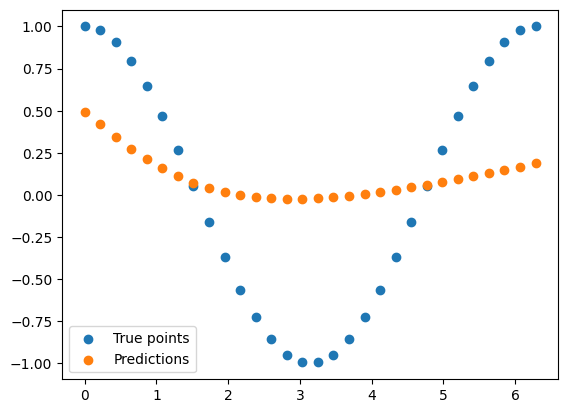

Avg loss: 0.379918 

Epoch: 15


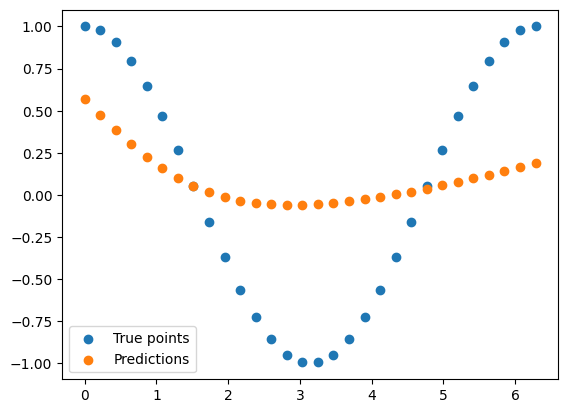

Avg loss: 0.355363 

Epoch: 40


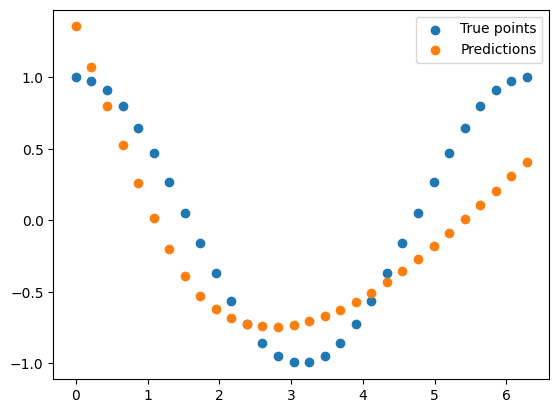

Avg loss: 0.146487 

Epoch: 80


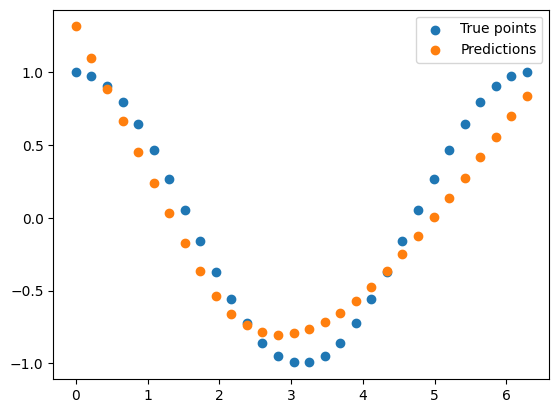

Avg loss: 0.045889 

Epoch: 120


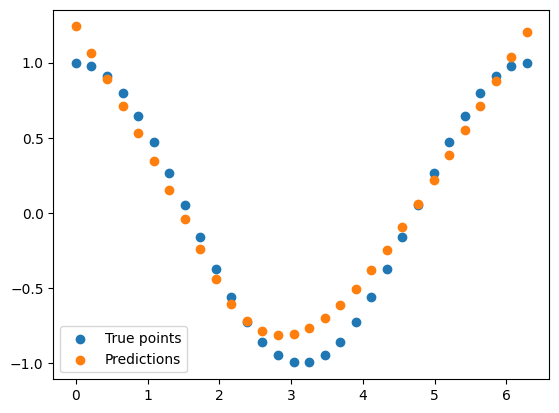

Avg loss: 0.018157 

Epoch: 160


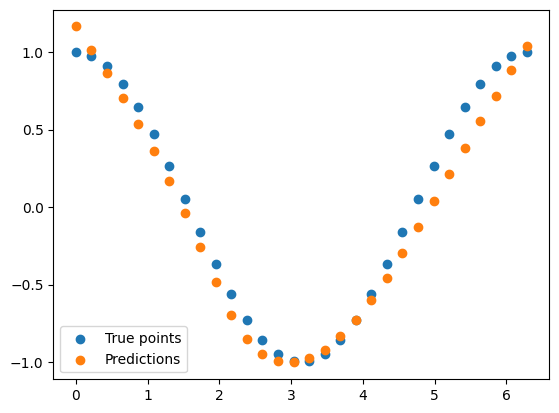

Avg loss: 0.016763 

Epoch: 200


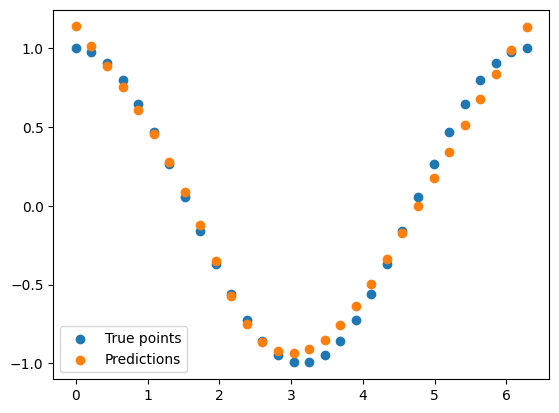

Avg loss: 0.005239 

Done!


In [17]:
cos_standard_train_losses = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    cos_standard_train_losses.append(train_loop(cos_train_dataloader, cos_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(cos_test_dataloader, cos_model, loss_function)
print("Done!")

Epoch: 1


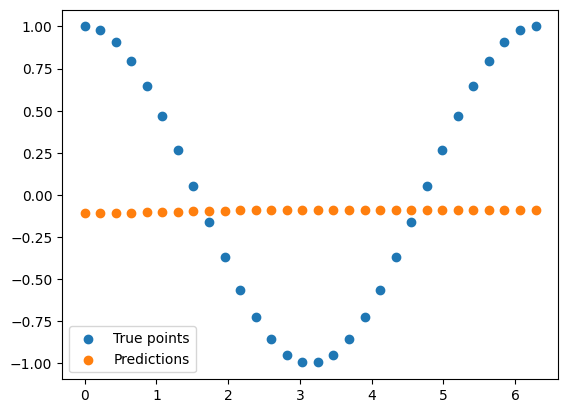

Avg loss: 0.537575 

Epoch: 2


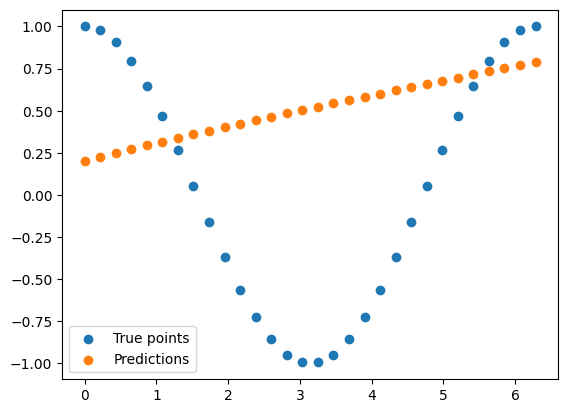

Avg loss: 0.779669 

Epoch: 3


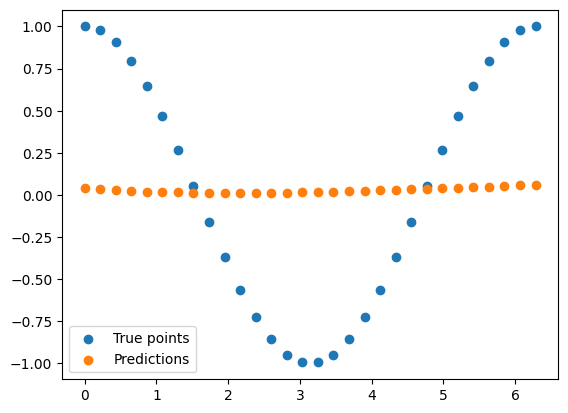

Avg loss: 0.501471 

Epoch: 4


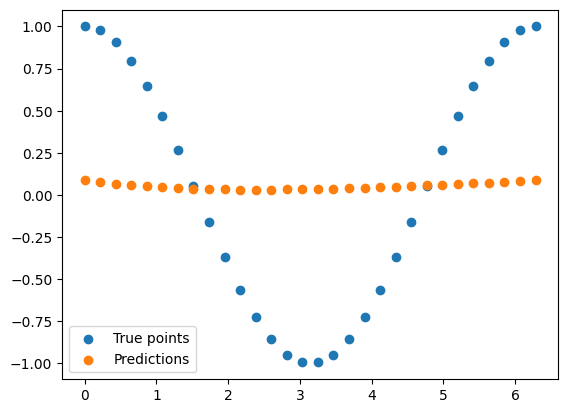

Avg loss: 0.493743 

Epoch: 5


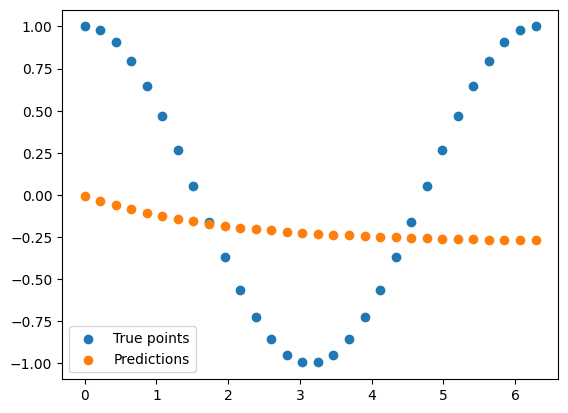

Avg loss: 0.536469 

Epoch: 6


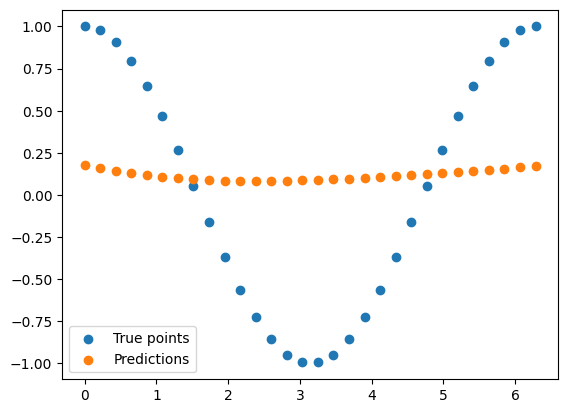

Avg loss: 0.486267 

Epoch: 7


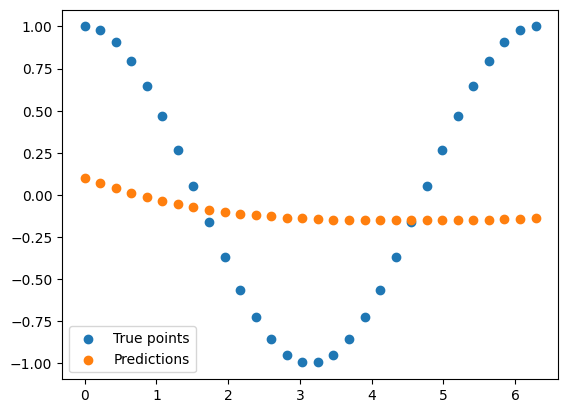

Avg loss: 0.486072 

Epoch: 8


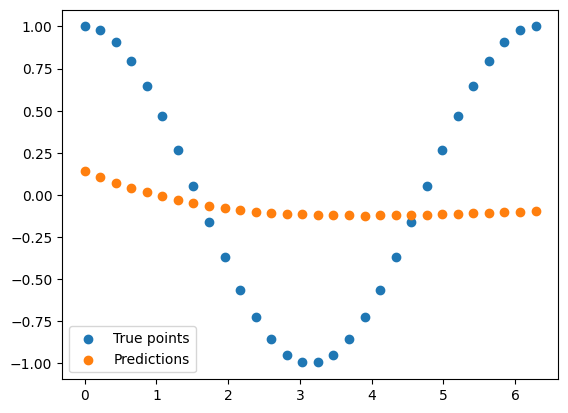

Avg loss: 0.470716 

Epoch: 9


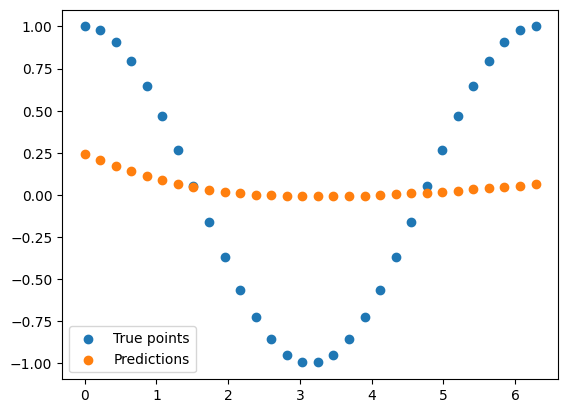

Avg loss: 0.450234 

Epoch: 10


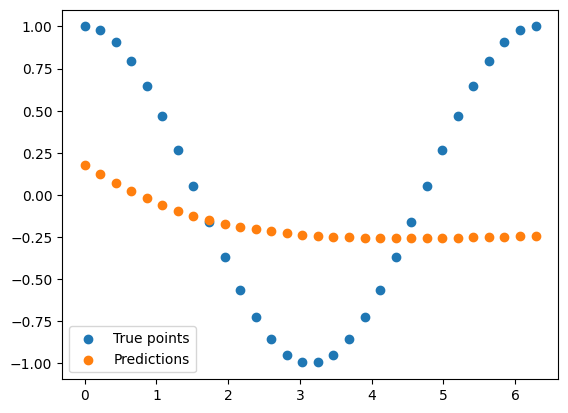

Avg loss: 0.482148 

Epoch: 11


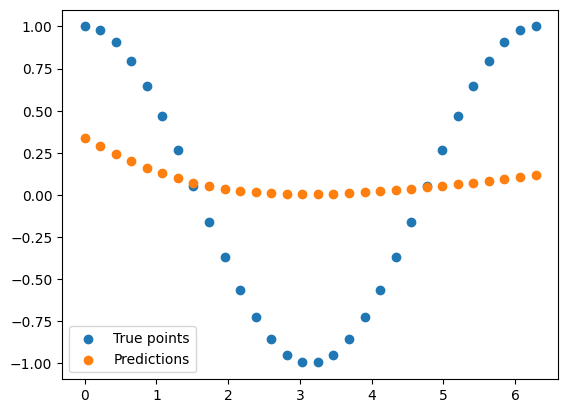

Avg loss: 0.428570 

Epoch: 12


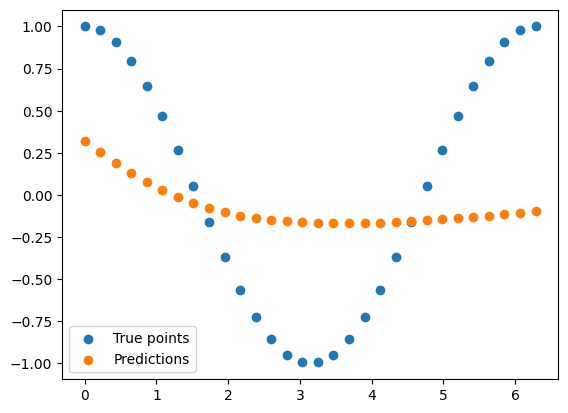

Avg loss: 0.424626 

Epoch: 13


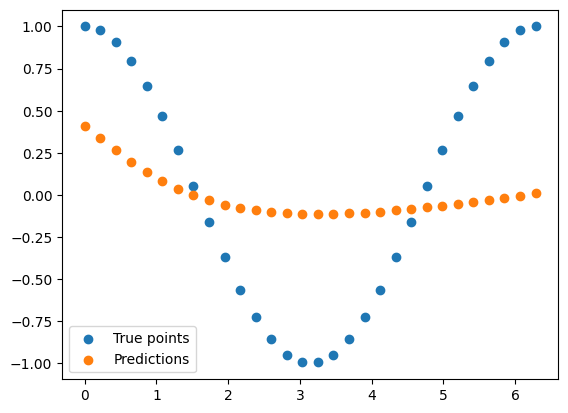

Avg loss: 0.396015 

Epoch: 14


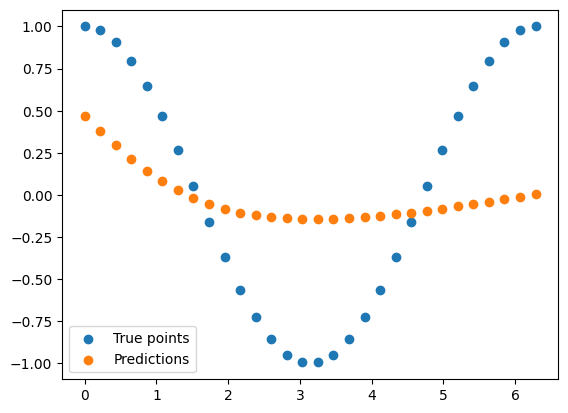

Avg loss: 0.378462 

Epoch: 15


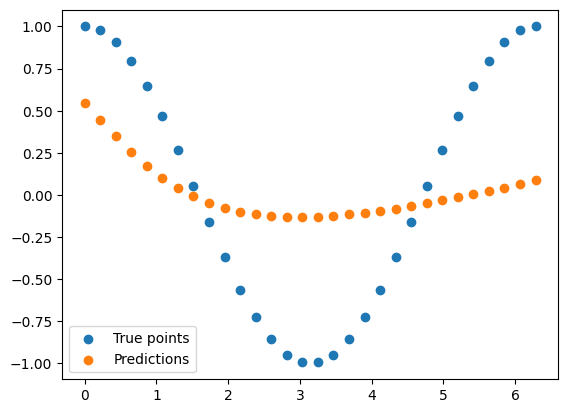

Avg loss: 0.352579 

Epoch: 40


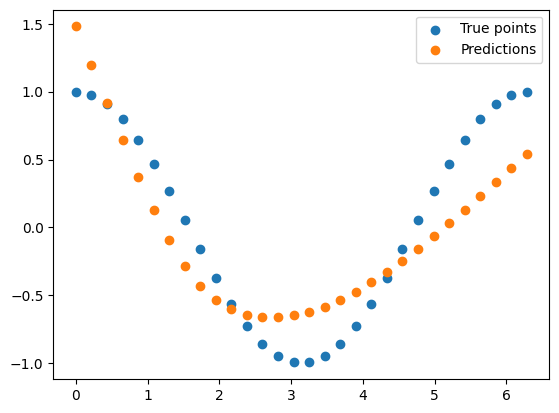

Avg loss: 0.110810 

Epoch: 80


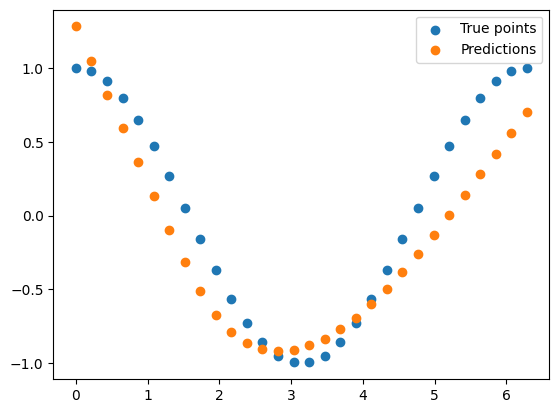

Avg loss: 0.082749 

Epoch: 120


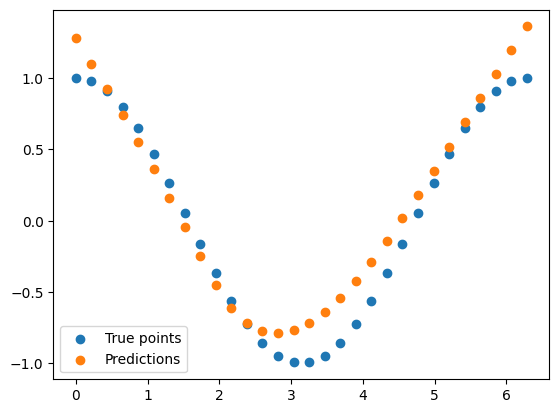

Avg loss: 0.033128 

Epoch: 160


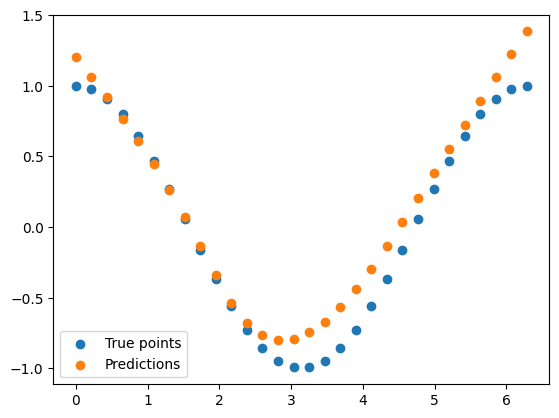

Avg loss: 0.029669 

Epoch: 200


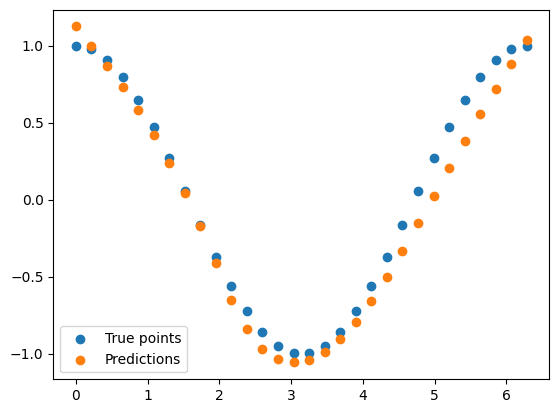

Avg loss: 0.016306 

Done!


In [18]:
training_optimizer = torch.optim.SGD(cos_precond_model.parameters(), lr=learning_rate)
cos_precond_training_losses = []
for t in range(epochs):
    
    cos_precond_training_losses.append(train_loop(cos_train_dataloader, cos_precond_model, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(cos_test_dataloader, cos_precond_model, loss_function)
print("Done!")

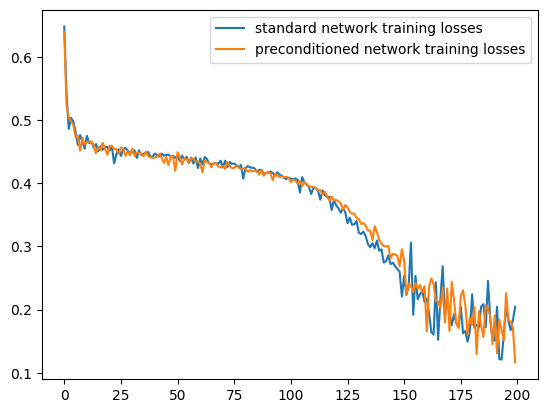

In [19]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
plt.legend()